In [41]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from jax.random import PRNGKey, split
from jax import config, grad
from time import time
# config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix, generate_sensing_matrices
from loss import create_mc_loss
from network import init_net, create_network, compute_prefactor, compress_network
from solver import train
from utils import svd, sensing_operator, compose

In [42]:
key = PRNGKey(0)

r = 5
input_dim = 2000
output_dim = 2000
depth = 3
init_type = "orth"
init_scale = 1e-3

key, target_key = split(key)
target = generate_data(key=target_key, shape=(output_dim, input_dim), rank=r)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network()

key, observation_key = split(key)
percent_observed = 0.2
observation_matrix = generate_observation_matrix(observation_key, percent_observed, (output_dim, input_dim))
mc_loss_fn = create_mc_loss(target, observation_matrix)
e2e_loss_fn = compose(mc_loss_fn, network_fn)

## Full width

In [51]:
num_iters = 70000
step_size = 1e3
weights, loss_list, time_list = train(
    init_weights=init_weights,
    e2e_loss_fn=e2e_loss_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=False,
    save_weights=False
)

  0%|          | 0/700 [00:00<?, ?it/s]

## Compressed

In [43]:
V = compute_prefactor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=r)
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_init_weights = [V1_1.T] + comp_init_weights + [UL_1]

In [44]:
num_iters = 70000
step_size = 1e3
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    e2e_loss_fn=e2e_loss_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=True,
    save_weights=False
)

  0%|          | 0/700 [00:00<?, ?it/s]

## Width=r

In [45]:
key, weight_key = split(key)
narrow_r_init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=r, depth=depth, init_type="orth", init_scale=init_scale)

In [46]:
num_iters = 500000
step_size = 1e3
narrow_r_weights, narrow_r_loss_list, narrow_r_time_list = train(
    init_weights=narrow_r_init_weights,
    e2e_loss_fn=e2e_loss_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=False,
    save_weights=False
)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Width=2r

In [47]:
key, weight_key = split(key)
narrow_2r_init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=2*r, depth=depth, init_type="orth", init_scale=init_scale)

In [49]:
num_iters = 220000
step_size = 1e3
narrow_2r_weights, narrow_2r_loss_list, narrow_2r_time_list = train(
    init_weights=narrow_2r_init_weights,
    e2e_loss_fn=e2e_loss_fn,
    n_epochs=num_iters,
    step_size=step_size,
    n_inner_loops=100,
    factors=False,
    save_weights=False
)

  0%|          | 0/2200 [00:00<?, ?it/s]

## Plotting

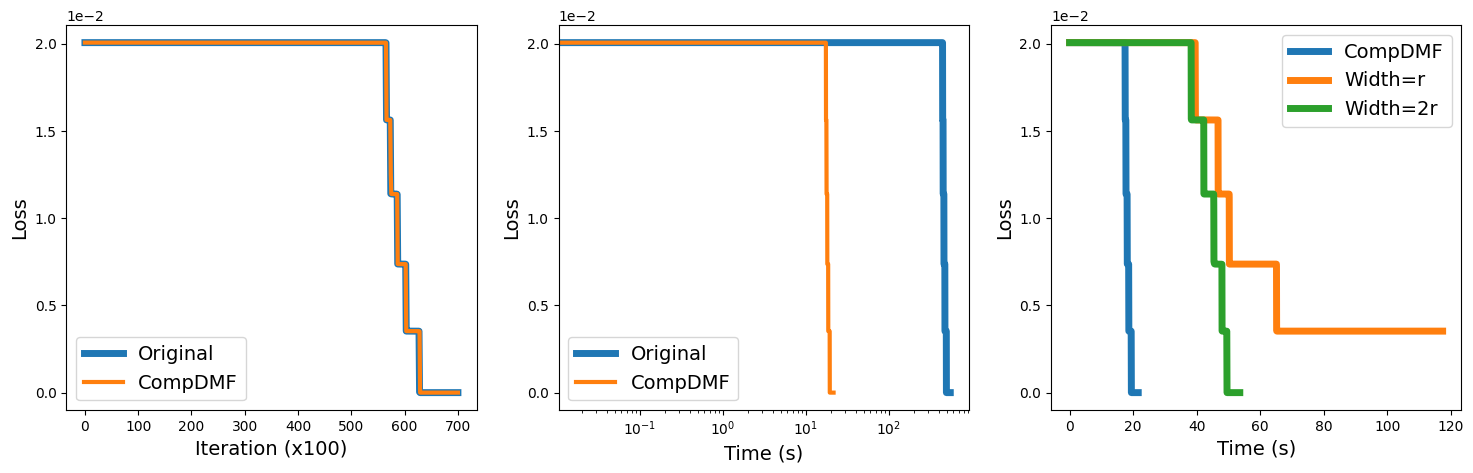

In [90]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(loss_list, linewidth=5, label='Original')
axes[0].plot(comp_loss_list, linewidth=3, label='CompDMF')
axes[0].set_xlabel('Iteration (x100)', fontsize=14)
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].locator_params(axis='y', nbins=6)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].legend(fontsize=14)

axes[1].semilogx(time_list, loss_list, linewidth=5, label='Original')
axes[1].semilogx(comp_time_list, comp_loss_list, linewidth=3, label='CompDMF')
axes[1].set_xlabel('Time (s)', fontsize=14)
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1].locator_params(axis='y', nbins=6)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].legend(fontsize=14)

axes[2].plot(comp_time_list, comp_loss_list, linewidth=5, label='CompDMF')
axes[2].plot(narrow_r_time_list, narrow_r_loss_list, linewidth=5, label='Width=r')
axes[2].plot(narrow_2r_time_list, narrow_2r_loss_list, linewidth=5, label='Width=2r')
axes[2].set_xlabel('Time (s)', fontsize=14)
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[2].locator_params(axis='y', nbins=6)
axes[2].set_ylabel('Loss', fontsize=14)
axes[2].legend(fontsize=14)

plt.savefig('figs/app2_widths.png', dpi=300, bbox_inches='tight')